# Goal: Fine tune a LLM model on an instruction dataset

This notebook needs to be completed. There are placeholders for each of the following tasks which need to be coded up. Finally, this notebook should be runnable on a free Google colab instance in few minutes.

## Concrete tasks:
1. Load the instruction fine-tuning dataset
2. Load the model and tokenizer
3. Prompt the model with few items from the dataset and print the generated responses using the provided `generate()` function
4. Implement a trainer class that takes the model, dataset as inputs and
  - Instantiates necessary training components such as optimizer, learning rate scheduler etc.
  - Specifically, implement the `train()` function that performs the classic train loop with a next-token prediction objective
5. Modify the `generate()` function to implement the generation logic directly using `model.forward()`. At each generation step, generated tokens are fed as inputs until the stopping condition is met (EOS is generated or max_tokens is reached). Most importantly, make sure that the generations are batched.
6. **Plot the effect of training data on the validation loss**: The idea is to vary the amount of data used for training data (e.g. 100, 200, 500, 1000 data points) and understand its effect on the valiation loss. Please provide an explanation along with the plot. 
7. **Applying Chat template**: Suppose you want to switch to a different model and accordingly the prompt template needs to change. So, how would you incorporate this change without having to manually apply the template everytime you change the model.

Bonus points:
- You are free to use any model. But if you use a larger model (e.g. Llama model 7-B) and make it trainable on Google Colab with T4 instance in couple of minutes, it is a bonus point.
Hint: you should use techniques such **LoRA/QLoRa** to reduce the number of trainable parameters, use **quantization** to reduce the memory requirements.
- Optimize the `generate()` further to use attention key-value caching. The idea is that we do not want to recompute attention values for our prompt at every decoding step.

# Install Dependencies
If you add any new depencies, make sure to update the following cell accordingly.

In [ ]:
!pip install -q accelerate peft transformers bitsandbytes datasets trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 642.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━

# Imports
All imports should be added below.

In [ ]:
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import torch
from huggingface_hub import notebook_login

## 1. Load the instruction fine-tuning dataset

In [ ]:
dataset = load_dataset("yizhongw/self_instruct")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for yizhongw/self_instruct contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/yizhongw/self_instruct
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `dataset

Generating train split:   0%|          | 0/82612 [00:00<?, ? examples/s]

## 2. Load model and tokenizer

In [ ]:
################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

In [ ]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Load the entire model on the GPU 0
device_map = {"": 0}

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# The model that you want to train from the Hugging Face hub
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map,
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
#tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

## 3. Prompt the model with few items from the dataset

In [ ]:
prompts = [item for item in dataset["train"]["prompt"][:2]]
print(prompts)

['Make a list of 10 ways to help students improve their study skills.\n\nOutput:', 'Task: Find out what are the key topics in the document? output "topic 1", "topic 2", ... , "topic n".\n\nThe United States has withdrawn from the Paris Climate Agreement.\n\n']


In [ ]:
def generate(prompts):
  pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200, return_full_text=False)
  result = pipe(prompts)
  generated_texts = [item[0]["generated_text"] for item in result]
  return generated_texts

In [ ]:
gen_texts = generate(prompts)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
for prompt, text in zip(prompts, gen_texts):
  print("#############")
  print(f"PROMPT: {prompt}")
  print(f"RESPONSE: {text}")

#############
PROMPT: Make a list of 10 ways to help students improve their study skills.

Output:
RESPONSE: 

1. Create a study schedule: Encourage students to create a study schedule that includes regular study sessions, breaks, and time for review.
2. Eliminate distractions: Encourage students to eliminate distractions while studying, such as turning off their phone or finding a quiet study space.
3. Use active learning techniques: Encourage students to use active learning techniques, such as taking notes, summarizing information, or creating flashcards.
4. Use mnemonic devices: Encourage students to use mnemonic devices to help them remember information, such as acronyms or rhymes.
5. Practice regularly: Encourage students to practice regularly, rather than cramming the night before a test.
6. Take breaks: Encourage students to take breaks during long study sessions to rest
#############
PROMPT: Task: Find out what are the key topics in the document? output "topic 1", "topic 2", ..

## 4. Implement a trainer class
- The class must take model, dataset and instantiates necessary training components such as optimizer, learning rate scheduler etc.
- Specifically, implement the `train()` function that performs the classic train loop with a next-token prediction objective

```
trainer = Trainer(model, dataset, train_args, ...)
trainer.train()
```

Bonus Point: Use techniques such LoRA/QLoRa to reduce the number of trainable parameters, use quantization to reduce the memory requirements.

In [ ]:
# Parameter-Efficient Fine-Tuning (PEFT) 
# it enables efficient adaptation of pre-trained models to downstream applications without fine-tuning all the model’s parameters. 
# PEFT supports the widely-used Low-Rank Adaptation of Large Language Models (LoRA).

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

peft_model = prepare_model_for_kbit_training(model)

# QLoRa config
config = LoraConfig(
    r=64, # LoRA Dimension / Rank of Decomposition
    lora_alpha=16, # Alpha Parameter for LoRA Scaling 
    lora_dropout=0.1, # Dropout Probability for LoRA Layers 
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"], # Modules to Apply LoRA to 
    bias="none", # Bias Type for Lora
    task_type="CAUSAL_LM", # Task Type 
)

# Enabling gradient checkpointing to reduce memory usage during fine-tuning
peft_model.gradient_checkpointing_enable()

peft_model = get_peft_model(peft_model, config)

In [ ]:
# split data for train and evaluation
splitted_data = dataset['train'].train_test_split(test_size=0.3)

## TrainingArguments
The TrainingArguments class is part of the Hugging Face Transformers library, which is widely used for natural language processing tasks such as text classification, language modeling, and translation. 
TrainingArguments is a configuration class that allows you to specify various training options and hyperparameters for training neural network models with Transformers.

Usage: 

TrainingArguments is typically used when initializing a trainer object for training a transformer-based model. It provides a convenient way to specify training options without the need to manually set each parameter.

Key Parameters:

output_dir: The directory where model checkpoints and other outputs will be saved during training.
per_device_train_batch_size: The batch size per GPU or CPU for training.
num_train_epochs: The number of training epochs.
learning_rate: The learning rate for the optimizer.
weight_decay: The weight decay for regularization.
logging_dir: The directory where logs for training will be saved.
logging_steps: The number of training steps before logging metrics.
save_steps: The number of training steps before saving model checkpoints.
evaluation_strategy: The strategy for evaluating the model during training (e.g., "steps", "epoch").

## Supervised fine-tuning (or SFT for short)

Parameters

model — The model to train, can be a PreTrainedModel, a torch.nn.Module or a string with the model name to load from cache or download. The model can be also converted to a PeftModel if a PeftConfig object is passed to the peft_config argument.

args — The arguments to tweak for training. Please refer to the official documentation of transformers.TrainingArguments for more information.

data_collator  — The data collator to use for training.

train_dataset  — The dataset to use for training. We recommend users to use trl.trainer.ConstantLengthDataset to create their dataset.

eval_dataset (Optional[Union[datasets.Dataset, Dict[str, datasets.Dataset]]]) — The dataset to use for evaluation. We recommend users to use trl.trainer.ConstantLengthDataset to create their dataset.

tokenizer (Optionaltransformers.PreTrainedTokenizer) — The tokenizer to use for training. If not specified, the tokenizer associated to the model will be used.

model_init (Callable[[], transformers.PreTrainedModel]) — The model initializer to use for training. If None is specified, the default model initializer will be used.

compute_metrics (Callable[[transformers.EvalPrediction], Dict], optional defaults to None) — The function used to compute metrics during evaluation. It should return a dictionary mapping metric names to metric values. If not specified, only the loss will be computed during evaluation.

callbacks (List[transformers.TrainerCallback]) — The callbacks to use for training.

optimizers (Tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LambdaLR]) — The optimizer and scheduler to use for training.

preprocess_logits_for_metrics (Callable[[torch.Tensor, torch.Tensor], torch.Tensor]) — The function to use to preprocess the logits before computing the metrics.

peft_config (Optional[PeftConfig]) — The PeftConfig object to use to initialize the PeftModel.

dataset_text_field (Optional[str]) — The name of the text field of the dataset, in case this is passed by a user, the trainer will automatically create a ConstantLengthDataset based on the dataset_text_field argument.

formatting_func (Optional[Callable]) — The formatting function to be used for creating the ConstantLengthDataset.

max_seq_length (Optional[int]) — The maximum sequence length to use for the ConstantLengthDataset and for automatically creating the Dataset. Defaults to 512.

infinite (Optional[bool]) — Whether to use an infinite dataset or not. Defaults to False.

num_of_sequences (Optional[int]) — The number of sequences to use for the ConstantLengthDataset. Defaults to 1024.

chars_per_token (Optional[float]) — The number of characters per token to use for the ConstantLengthDataset. Defaults to 3.6. You can check how this is computed in the stack-llama example: https://github.com/huggingface/trl/blob/08f550674c553c36c51d1027613c29f14f3676a5/examples/stack_llama/scripts/supervised_finetuning.py#L53.

packing (Optional[bool]) — Used only in case dataset_text_field is passed. This argument is used by the ConstantLengthDataset to pack the sequences of the dataset.

dataset_num_proc (Optional[int]) — The number of workers to use to tokenize the data. Only used when packing=False. Defaults to None.

dataset_batch_size (int) — The number of examples to tokenize per batch. If batch_size <= 0 or batch_size == None, tokenize the full dataset as a single batch. Defaults to 1000.

neftune_noise_alpha (Optional[float]) — If not None, this will activate NEFTune noise embeddings. This has been proven to drastically improve model performances for instruction fine-tuning. Check out the original paper here: https://arxiv.org/abs/2310.05914 and the original code here: https://github.com/neelsjain/NEFTune 

model_init_kwargs — (Optional[Dict], optional): Dict of Optional kwargs to pass when instantiating the model from a string 

dataset_kwargs — (Optional[Dict], optional): Dict of Optional kwargs to pass when creating packed or non-packed datasets eval_packing — (Optional[bool], optional): Whether to pack the eval dataset as well. Defaults to packing if None is passed.

In [ ]:
## build Trainer using SFTTrainer
import time
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from trl import SFTTrainer # for train speed up

output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir = output_dir,
    learning_rate=1e-3,
    per_device_train_batch_size=8, # depends on GPU
    per_device_eval_batch_size=8, # depends on GPU
    num_train_epochs=1,
    weight_decay=0.001,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    fp16=True,
    gradient_checkpointing=True,
    overwrite_output_dir = 'True',
    max_grad_norm=0.3,
    max_steps=200, # set small for time saving, in practice -1 is good
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
)

peft_model.config.use_cache = False
peft_model.enable_input_require_grads() # to input variable has grad_fn

# Setting sft parameters
trainer = SFTTrainer(
    model=peft_model,
    train_dataset=splitted_data['train'],
    eval_dataset=splitted_data['test'],
    peft_config=config,
    max_seq_length=None,
    dataset_text_field="prompt",
    tokenizer=tokenizer,
    args=training_args,
    packing= False,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:245: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:317: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

You are using 8-bit optimizers with a version of `bitsandbytes` < 0.41.1. It is recommended to update your version as a major bug has been fixed in 8-bit optimizers.


Epoch,Training Loss,Validation Loss
0,12.859600,10.749925


TrainOutput(global_step=200, training_loss=12.859564208984375, metrics={'train_runtime': 940.2589, 'train_samples_per_second': 6.807, 'train_steps_per_second': 0.213, 'total_flos': 1.067129194119168e+16, 'train_loss': 12.859564208984375, 'epoch': 0.11})

In [ ]:
# save finetunned model
trainer.model.save_pretrained('my_model')
peft_model.config.use_cache = False
peft_model.eval()

## 5. Implement your own generation logic

Modify the `generate()` function to implement the generation logic directly using `model.forward()` instead of using pipeline API. At each generation step, generated tokens are fed as inputs until the stopping condition is met (EOS is generated or max_tokens is reached). Most importantly, make sure that the generations are batched.

Bonus Point:
- Optimize the `generate()` further to use attention key-value caching.


In the context of Language Model (LLM), a "KV cache" could refer to a key-value cache used to efficiently store and retrieve intermediate representations or embeddings of tokens or sequences generated by the language model during inference or training.

In [ ]:
from tqdm import tqdm

def get_input_ids(prompt: str) -> torch.Tensor:
    tokens = tokenizer(prompt, return_tensors="pt").input_ids.to('cuda')
    return tokens
def tokens_to_text(tokens: torch.Tensor):
    return tokenizer.batch_decode(tokens, skip_special_tokens=True)

def modified_generate(prompt, max_new_tokens=10):
  tokens = get_input_ids(prompt)
  cached = None # KV cache
  for _ in tqdm(range(max_new_tokens)):
    with torch.no_grad():
        if cached is None:
            mout = model(tokens, output_hidden_states=True, use_cache=True)
            cached = mout.past_key_values
        else:
            mout = model(tokens, past_key_values=cached, use_cache=True, output_hidden_states=True)
            cached = mout.past_key_values
    tokens = torch.hstack((tokens, torch.argmax(mout.logits[0, -1]).unsqueeze(0).unsqueeze(0)))

  with_cache = tokens_to_text(tokens)[0]
  print(f"{with_cache=}")

  return with_cache

In [ ]:
# generate 9 tokens
modified_generate(prompts[0], max_new_tokens=9)

100%|██████████| 9/9 [00:04<00:00,  2.09it/s]

with_cache='Make a list of 10 ways to help students improve their study skills.\n\nOutput:\n\n1. Encourage students to'


'Make a list of 10 ways to help students improve their study skills.\n\nOutput:\n\n1. Encourage students to'

In [ ]:
# generate 10 tokens
modified_generate(prompts[0], max_new_tokens=10)

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

with_cache='Make a list of 10 ways to help students improve their study skills.\n\nOutput:\n\n1. Encourage students to make'


'Make a list of 10 ways to help students improve their study skills.\n\nOutput:\n\n1. Encourage students to make'

In [ ]:
# generate 15 tokens
modified_generate(prompts[0], max_new_tokens=15)

100%|██████████| 15/15 [00:07<00:00,  1.97it/s]

with_cache='Make a list of 10 ways to help students improve their study skills.\n\nOutput:\n\n1. Encourage students to make a list of 1'


'Make a list of 10 ways to help students improve their study skills.\n\nOutput:\n\n1. Encourage students to make a list of 1'

In [ ]:
# generate 20 tokens
modified_generate(prompts[0], max_new_tokens=20)

100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


with_cache='Make a list of 10 ways to help students improve their study skills.\n\nOutput:\n\n1. Encourage students to make a list of 10 ways to help students'


'Make a list of 10 ways to help students improve their study skills.\n\nOutput:\n\n1. Encourage students to make a list of 10 ways to help students'

## 6. Plot the effect of training data on the validation loss: 
The idea is to vary the amount of data used for training data (e.g. 100, 200, 500, 1000 data points) and understand its effect on the valiation loss. Please provide an explanation along with the plot. 

In [ ]:
dataset100 = dataset['train'].select(range(125))
splitted_data = dataset100.train_test_split(test_size=0.2)

In [ ]:
# just re-define training arguments for train speeding up
training_args_1 = TrainingArguments(
    output_dir = output_dir,
    learning_rate=1e-3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.001,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    fp16=True,
    gradient_checkpointing=True,
    overwrite_output_dir = 'True',
    max_grad_norm=0.3,
    max_steps=30,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
)

In [ ]:
trainer100 = SFTTrainer(
    model=peft_model,
    train_dataset=splitted_data['train'],
    eval_dataset=splitted_data['test'],
    peft_config=config,
    max_seq_length=None,
    dataset_text_field="prompt",
    tokenizer=tokenizer,
    args=training_args_1,
    packing= False,
)
trainer100.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:245: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:317: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_re

Epoch,Training Loss,Validation Loss
0,0.949500,1.963338
1,0.654800,2.370183
2,0.544800,2.404170
4,0.615400,2.192410
5,0.421900,2.442783
6,0.357700,2.327241
8,1.489800,2.760145
9,1.354600,2.760145


Checkpoint destination directory ./peft-dialogue-summary-training-1711114003/checkpoint-3 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Checkpoint destination directory ./peft-dialogue-summary-training-1711114003/checkpoint-6 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default va

TrainOutput(global_step=30, training_loss=0.6490751743316651, metrics={'train_runtime': 383.4438, 'train_samples_per_second': 2.504, 'train_steps_per_second': 0.078, 'total_flos': 2059405489963008.0, 'train_loss': 0.6490751743316651, 'epoch': 9.23})

In [ ]:
dataset200 = dataset['train'].select(range(250))
splitted_data = dataset200.train_test_split(test_size=0.2)
trainer200 = SFTTrainer(
    model=peft_model,
    train_dataset=splitted_data['train'],
    eval_dataset=splitted_data['test'],
    peft_config=config,
    max_seq_length=None,
    dataset_text_field="prompt",
    tokenizer=tokenizer,
    args=training_args_1,
    packing= False,
)
trainer200.train()

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,2.272300,1.819052
1,1.350600,2.316737
2,0.993800,1.920284
4,0.455100,2.506646


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

TrainOutput(global_step=30, training_loss=1.1230154434839885, metrics={'train_runtime': 342.4809, 'train_samples_per_second': 2.803, 'train_steps_per_second': 0.088, 'total_flos': 2220693605646336.0, 'train_loss': 1.1230154434839885, 'epoch': 4.8})

In [ ]:
trainer100.state.log_history

[{'loss': 0.9495,
  'grad_norm': 1.371364712715149,
  'learning_rate': 0.001,
  'epoch': 0.92,
  'step': 3},
 {'eval_loss': 1.9633384943008423,
  'eval_runtime': 3.63,
  'eval_samples_per_second': 6.887,
  'eval_steps_per_second': 1.102,
  'epoch': 0.92,
  'step': 3},
 {'loss': 0.6548,
  'grad_norm': 0.9185757040977478,
  'learning_rate': 0.001,
  'epoch': 1.85,
  'step': 6},
 {'eval_loss': 2.370182991027832,
  'eval_runtime': 3.5382,
  'eval_samples_per_second': 7.066,
  'eval_steps_per_second': 1.131,
  'epoch': 1.85,
  'step': 6},
 {'loss': 0.5448,
  'grad_norm': 0.7719460129737854,
  'learning_rate': 0.001,
  'epoch': 2.77,
  'step': 9},
 {'eval_loss': 2.404170036315918,
  'eval_runtime': 3.5886,
  'eval_samples_per_second': 6.966,
  'eval_steps_per_second': 1.115,
  'epoch': 2.77,
  'step': 9},
 {'loss': 0.5368,
  'grad_norm': nan,
  'learning_rate': 0.001,
  'epoch': 4.0,
  'step': 13},
 {'eval_loss': 2.404170036315918,
  'eval_runtime': 3.5669,
  'eval_samples_per_second': 7.009

In [ ]:
trainer200.state.log_history

[{'loss': 2.2723,
  'grad_norm': 0.46501001715660095,
  'learning_rate': 0.001,
  'epoch': 0.96,
  'step': 6},
 {'eval_loss': 1.81905198097229,
  'eval_runtime': 6.3302,
  'eval_samples_per_second': 7.899,
  'eval_steps_per_second': 1.106,
  'epoch': 0.96,
  'step': 6},
 {'loss': 1.3506,
  'grad_norm': 10.637598037719727,
  'learning_rate': 0.001,
  'epoch': 1.92,
  'step': 12},
 {'eval_loss': 2.316737174987793,
  'eval_runtime': 6.5699,
  'eval_samples_per_second': 7.611,
  'eval_steps_per_second': 1.065,
  'epoch': 1.92,
  'step': 12},
 {'loss': 0.9938,
  'grad_norm': 0.6677022576332092,
  'learning_rate': 0.001,
  'epoch': 2.88,
  'step': 18},
 {'eval_loss': 1.9202842712402344,
  'eval_runtime': 6.7751,
  'eval_samples_per_second': 7.38,
  'eval_steps_per_second': 1.033,
  'epoch': 2.88,
  'step': 18},
 {'loss': 0.5307,
  'grad_norm': 0.5253007411956787,
  'learning_rate': 0.001,
  'epoch': 4.0,
  'step': 25},
 {'eval_loss': 2.060988426208496,
  'eval_runtime': 6.9266,
  'eval_sampl

In [ ]:
dataset500 = dataset['train'].select(range(625))
splitted_data = dataset500.train_test_split(test_size=0.2)
trainer500 = SFTTrainer(
    model=peft_model,
    train_dataset=splitted_data['train'],
    eval_dataset=splitted_data['test'],
    peft_config=config,
    max_seq_length=None,
    dataset_text_field="prompt",
    tokenizer=tokenizer,
    args=training_args_1,
    packing= False,
)
trainer500.train()
trainer500.state.log_history

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:245: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:317: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_re

Epoch,Training Loss,Validation Loss
0,1.723500,1.376092
1,0.825500,1.416993


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Checkpoint destination directory ./peft-dialogue-summary-training-1711121699/checkpoint-30 already exists and is non-empty. Saving will proceed but saved results may be invalid.


[{'loss': 1.7235,
  'grad_norm': 0.8075515627861023,
  'learning_rate': 0.001,
  'epoch': 0.95,
  'step': 15},
 {'eval_loss': 1.3760920763015747,
  'eval_runtime': 15.5409,
  'eval_samples_per_second': 8.043,
  'eval_steps_per_second': 1.03,
  'epoch': 0.95,
  'step': 15},
 {'loss': 0.8255,
  'grad_norm': 0.5448352694511414,
  'learning_rate': 0.001,
  'epoch': 1.9,
  'step': 30},
 {'eval_loss': 1.416993498802185,
  'eval_runtime': 16.2793,
  'eval_samples_per_second': 7.678,
  'eval_steps_per_second': 0.983,
  'epoch': 1.9,
  'step': 30},
 {'train_runtime': 311.3839,
  'train_samples_per_second': 3.083,
  'train_steps_per_second': 0.096,
  'total_flos': 1905205062107136.0,
  'train_loss': 1.2744612058003744,
  'epoch': 1.9,
  'step': 30}]

In [ ]:
dataset1000 = dataset['train'].select(range(1250))
splitted_data = dataset1000.train_test_split(test_size=0.2)
trainer1000 = SFTTrainer(
    model=peft_model,
    train_dataset=splitted_data['train'],
    eval_dataset=splitted_data['test'],
    peft_config=config,
    max_seq_length=None,
    dataset_text_field="prompt",
    tokenizer=tokenizer,
    args=training_args_1,
    packing= False,
)
trainer1000.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:245: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:317: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_re

Epoch,Training Loss,Validation Loss
0,1.424000,1.349912


Checkpoint destination directory ./peft-dialogue-summary-training-1711121699/checkpoint-30 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=30, training_loss=1.423996098836263, metrics={'train_runtime': 321.8457, 'train_samples_per_second': 2.983, 'train_steps_per_second': 0.093, 'total_flos': 1817559751655424.0, 'train_loss': 1.423996098836263, 'epoch': 0.96})

In [ ]:
trainer1000.state.log_history

[{'loss': 1.424,
  'grad_norm': 0.774896502494812,
  'learning_rate': 0.001,
  'epoch': 0.96,
  'step': 30},
 {'eval_loss': 1.3499115705490112,
  'eval_runtime': 34.9881,
  'eval_samples_per_second': 7.145,
  'eval_steps_per_second': 0.915,
  'epoch': 0.96,
  'step': 30},
 {'train_runtime': 321.8457,
  'train_samples_per_second': 2.983,
  'train_steps_per_second': 0.093,
  'total_flos': 1817559751655424.0,
  'train_loss': 1.423996098836263,
  'epoch': 0.96,
  'step': 30}]

In [ ]:
eval_losses = [2.7601447105407715, 2.506645679473877, 1.416993498802185 ,1.3499115705490112]
training_nums = [100, 200, 500, 1000]

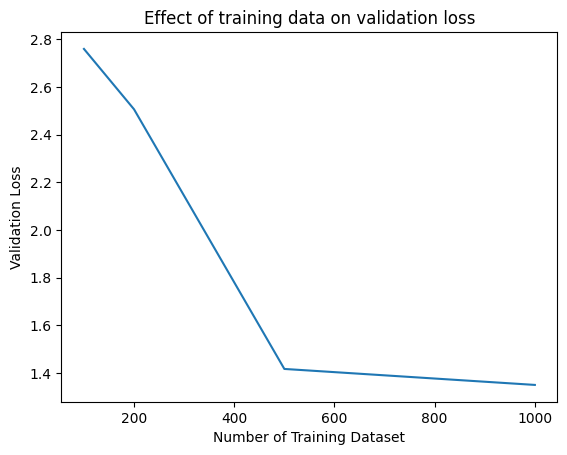

In [ ]:
# plot validation loss of various numbers of training data
# validation loss get lower while increasing number of training data
import matplotlib.pyplot as plt

plt.plot(training_nums, eval_losses)
plt.title('Effect of training data on validation loss')
plt.xlabel('Number of Training Dataset')
plt.ylabel('Validation Loss')
plt.show()

## 7. Applying Chat template: 
Suppose you want to switch to a different model and accordingly the prompt template needs to change. So, how would you incorporate this change without having to manually apply the template everytime you change the model?

In [ ]:
# we consider BlenderBot model
model1 = AutoModelForCausalLM.from_pretrained("facebook/blenderbot-400M-distill")

pytorch_model.bin:   0%|          | 0.00/730M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

In [ ]:
tokenizer1 = AutoTokenizer.from_pretrained("facebook/blenderbot-400M-distill")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# example
chat = [
   {"role": "user", "content": "Hello, how are you?"},
   {"role": "assistant", "content": "I'm doing great. How can I help you today?"},
   {"role": "user", "content": "I'd like to show off how chat templating works!"},
]

 the tokenizer has added the control tokens [INST] and [/INST] to indicate the start and end of user messages (but not assistant messages!). Mistral-instruct was trained with these tokens, but BlenderBot was not.

In [ ]:
# If we use tokenize=True, which is the default setting, that string will also be tokenized for us. 
tokenizer.apply_chat_template(chat, tokenize=False) #  mistralai/Mistral-7B-Instruct-v0.1 model.

"<s>[INST] Hello, how are you? [/INST]I'm doing great. How can I help you today?</s>[INST] I'd like to show off how chat templating works! [/INST]"

the entire chat is condensed into a single string.

In [ ]:
tokenizer1.apply_chat_template(chat, tokenize=False) # facebook/blenderbot-400M-distill model


No chat template is defined for this tokenizer - using the default template for the BlenderbotTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



" Hello, how are you?  I'm doing great. How can I help you today?   I'd like to show off how chat templating works!</s>"

### text generation pipelines support chat inputs, which makes it easy to use chat models.

In [ ]:
tokenized_chat = tokenizer.apply_chat_template(chat, tokenize=True, add_generation_prompt=True, return_tensors="pt")
outputs = model.generate(tokenized_chat, max_new_tokens=128)
print(tokenizer.decode(outputs[0])) # a string in the input format that mistralai expects.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1477: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


<s> [INST] Hello, how are you? [/INST]I'm doing great. How can I help you today?</s> [INST] I'd like to show off how chat templating works! [/INST] Sure thing! I'd be happy to help you showcase chat templating. Could you please provide some context or an example of what you mean by "chat templating" and how you'd like to use it? That will help me better understand how I can assist you.

Chat templating can refer to a few different things, such as:

* Using templates to generate responses or messages in a chatbot or messaging application
* Using templates to format or structure the layout of a chat interface
* Using templates to generate HTML or other markup for a chat application

If you could please clar


In [ ]:
pipe = pipeline("text-generation", "mistralai/Mistral-7B-Instruct-v0.2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(pipe(chat, max_new_tokens=128)[0]['generated_text'])  

[{'role': 'user', 'content': 'Hello, how are you?'}, {'role': 'assistant', 'content': "I'm doing great. How can I help you today?"}, {'role': 'user', 'content': "I'd like to show off how chat templating works!"}, {'role': 'assistant', 'content': ''}]


In [ ]:
tokenized_chat = tokenizer1.apply_chat_template(chat, tokenize=True, add_generation_prompt=True, return_tensors="pt")
outputs = model1.generate(tokenized_chat, max_new_tokens=128)
print(tokenizer1.decode(outputs[0]))

 Hello, how are you?  I'm doing great. How can I help you today?   I'd like to show off how chat templating works!</s></s>


In [ ]:
pipe = pipeline("text-generation", "facebook/blenderbot-400M-distill")

In [ ]:
print(pipe(chat, max_new_tokens=128)[0]['generated_text'])  # Print the assistant's response

[{'role': 'user', 'content': 'Hello, how are you?'}, {'role': 'assistant', 'content': "I'm doing great. How can I help you today?"}, {'role': 'user', 'content': "I'd like to show off how chat templating works!"}, {'role': 'assistant', 'content': ''}]
